In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_3, get_X_4, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
electrons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(electrons_df, config=FIVE_LAYERS)
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
photons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(photons_df, config=FIVE_LAYERS)
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
pi0_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
pi_char_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(pi_char_df, config=FIVE_LAYERS)
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330809


## 1.5 Combined Particle Data

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
# combine the datasets
experiment = electrons + photons + pi0 + pi_char
del electrons, photons, pi0, pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)
experiment.dataset

1592160


,event_no,candidate_no,z,et,eta,phi,psb_eta,psb_phi,emb1_eta,emb1_phi,...,"hab1_(6,1)","hab1_(6,2)","hab1_(6,3)","hab1_(6,4)","hab1_(6,5)","hab1_(6,6)","hab1_(6,7)","hab1_(6,8)",tot_layers_et,physics_object_type
0,9193.0,0.0,-7.180069,24075.5000,1.319382,-1.371981,1.321907,-1.325359,1.320930,-1.325359,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,23946.485410,photon
1,98530.0,0.0,-184.554050,9856.2324,-0.740300,-0.362845,-0.868682,-0.343612,-0.826949,-0.343612,...,0.0,0.0,0.0,3.504673,0.0,0.0,0.0,0.0,2457.799834,pi_char
2,11208.0,0.0,139.242140,38519.9690,0.227940,0.076164,0.314740,0.049087,0.311083,0.049087,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,38026.168627,pi0
3,51266.0,0.0,90.253914,46398.1480,-0.099105,0.447424,-0.037769,0.539961,-0.007816,0.441786,...,0.0,0.0,0.0,9.275166,0.0,0.0,0.0,0.0,19348.645370,pi_char
4,82222.0,0.0,133.634170,30687.1740,0.161918,1.784357,0.314740,1.816233,0.245427,1.816233,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,30060.177299,photon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592155,6016.0,0.0,127.737980,48621.7730,0.385594,-0.218061,0.415457,-0.147262,0.458027,-0.245437,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,34091.308477,pi_char
1592156,70577.0,0.0,7.522919,5356.0669,1.158286,0.704133,1.170832,0.736311,1.161481,0.834486,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4490.551816,photon
1592157,30394.0,0.0,-177.516710,42309.1640,0.217675,-0.963621,0.088127,-0.932660,0.104736,-0.932660,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41343.518987,pi0
1592158,6106.0,0.0,-94.686325,18999.0740,-0.330126,1.874223,-0.390277,1.914408,-0.386118,1.914408,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,17799.738338,pi0


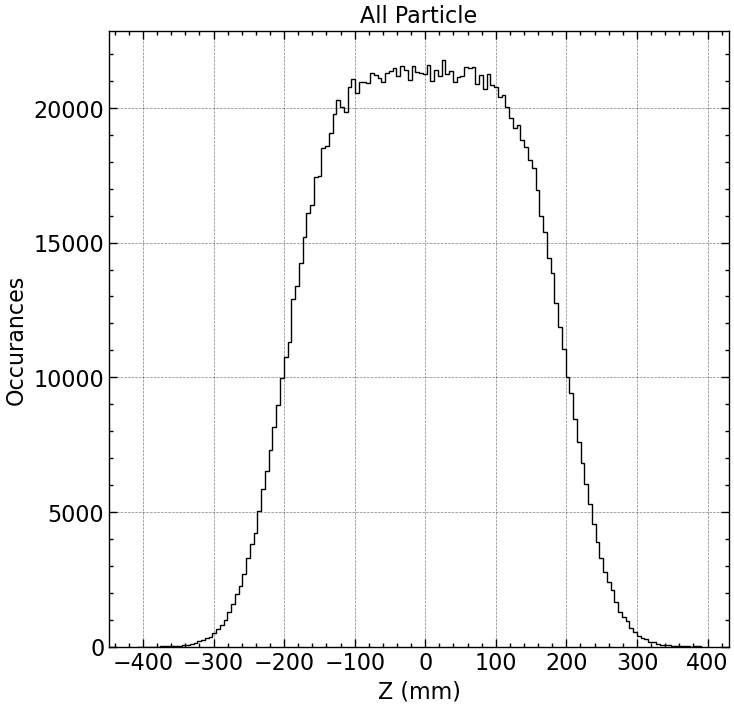

In [13]:
with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(8, 8))
    plt.hist(
        experiment.z,
        bins=150,
        histtype="step",
        label="Electrons",
        color="k",
        density=False,
    )
    plt.xlabel("Z (mm)")
    plt.ylabel("Occurances")
    plt.title("All Particle")
    plt.show()

# 2. Effect of Cut in Z

In [14]:
# hyperparameters used
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

## 2.1 Trained Without Cut, Tested Without Cut

In [15]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_train.shape)
print(experiment.X_test.shape)

experiment.train_xgboost_model(params)

(1273728, 22)
(318433, 22)
INFO: Trained XGBoost model; mean squared error: 3655.5840579032492


3655.5840579032492

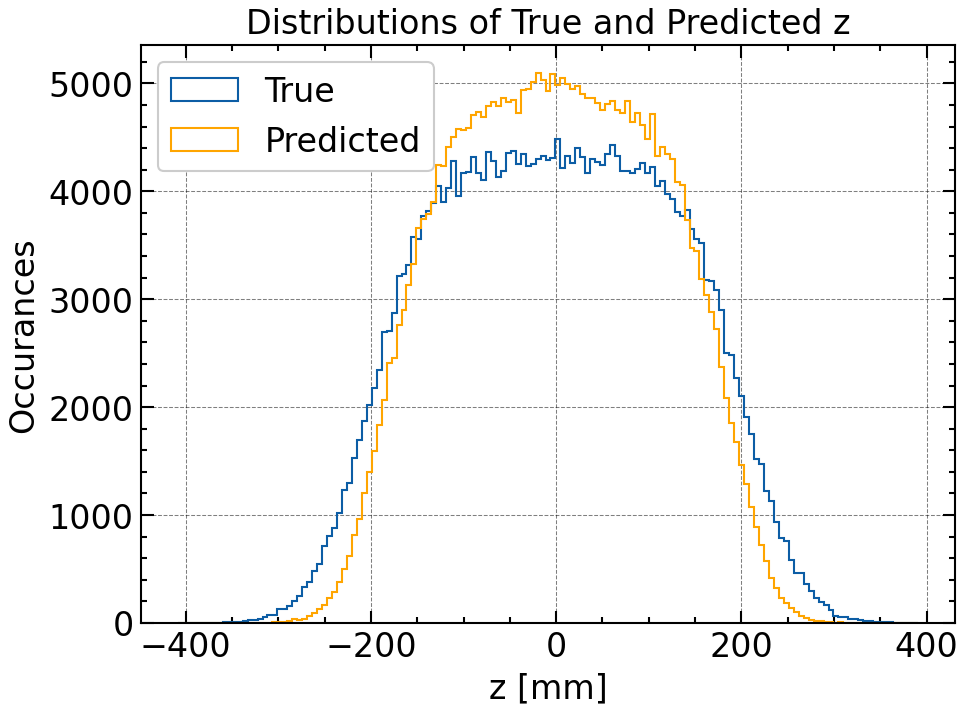

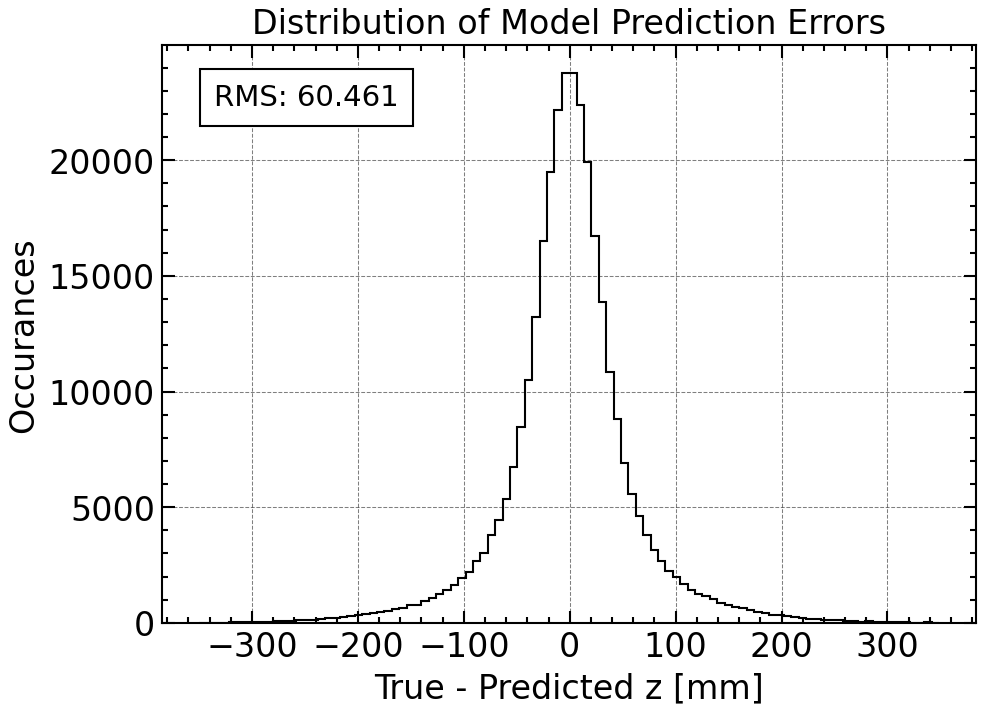

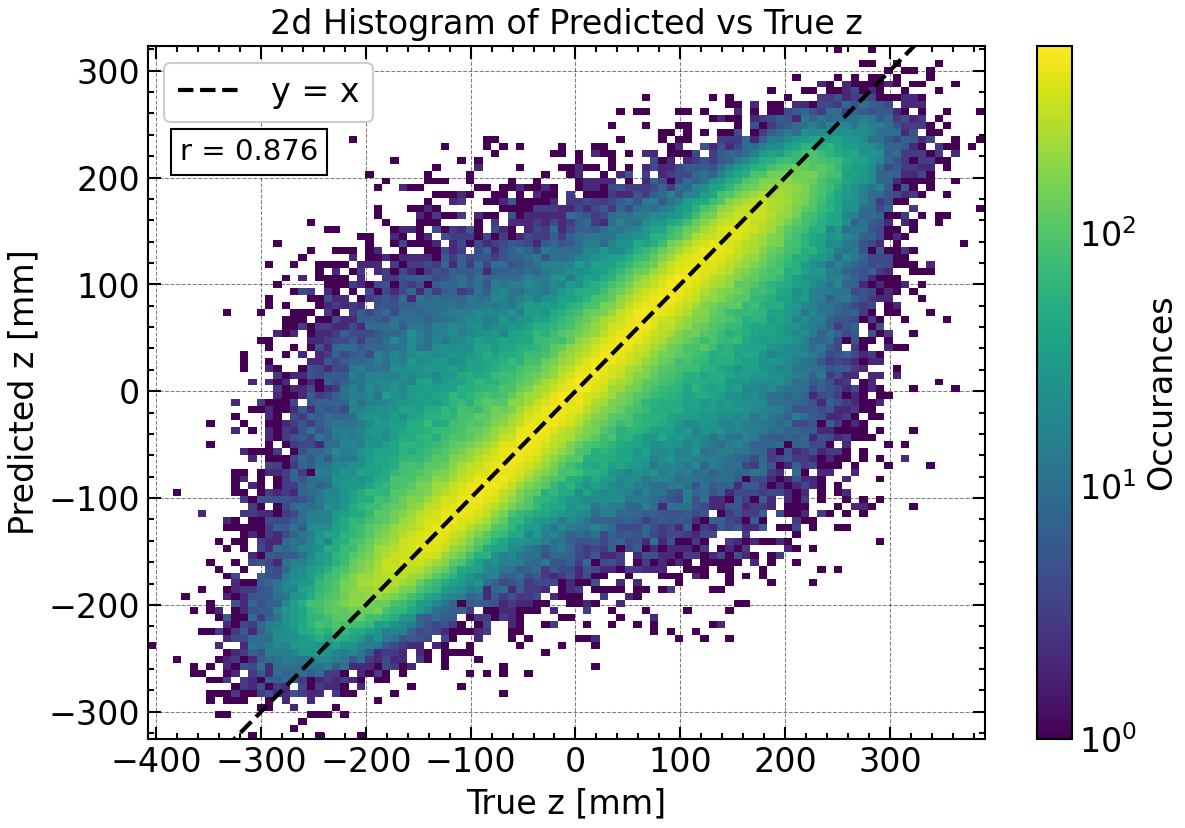

In [16]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

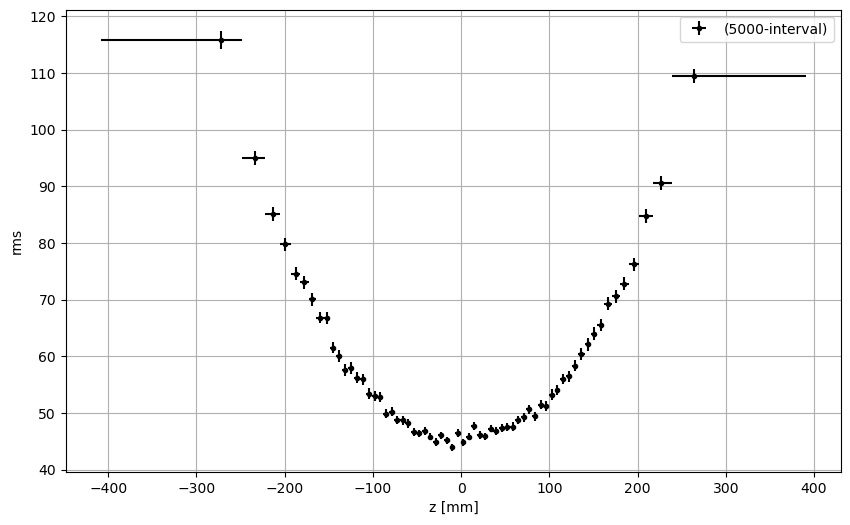

In [17]:
x_n, y_n, x_u_n, y_u_n = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

In [18]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

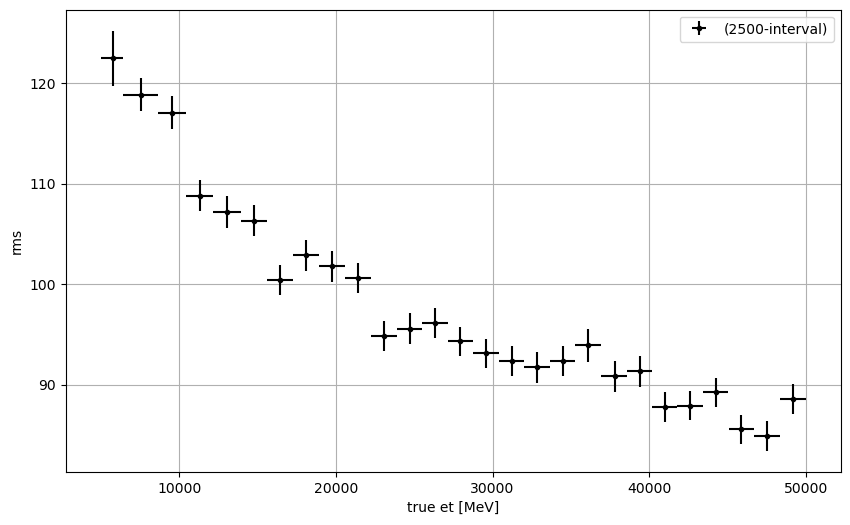

In [19]:
x_e_ne, y_e_ne, x_u_e_ne, u_e_ne = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

x_p_ne, y_p_ne, x_u_p_ne, u_p_ne = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi0_ne, y_pi0_ne, x_u_pi0_ne, u_pi0_ne = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi_char_ne, y_pi_char_ne, x_u_pi_char_ne, u_pi_char_ne = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

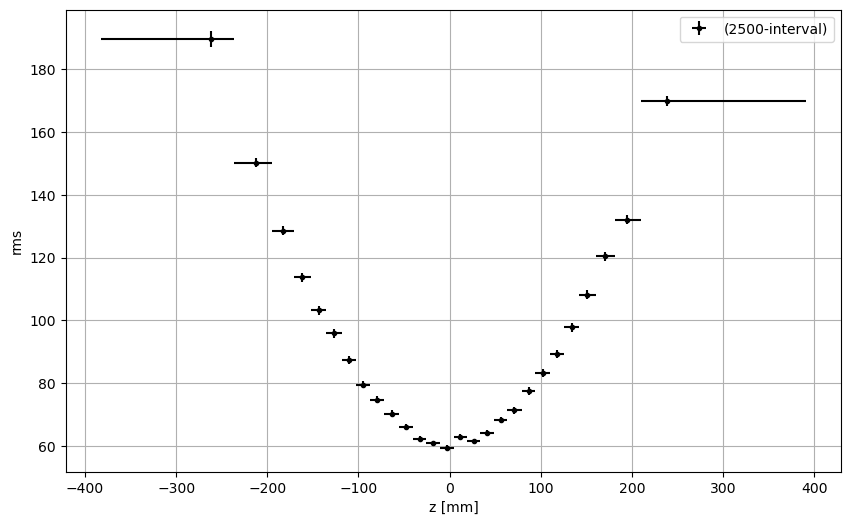

In [20]:
x_e_nz, y_e_nz, x_u_e_nz, u_e_nz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=3000,
    xlabel="z [mm]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

x_p_nz, y_p_nz, x_u_p_nz, u_p_nz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2500,
    xlabel="z [mm]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi0_nz, y_pi0_nz, x_u_pi0_nz, u_pi0_nz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="z [mm]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi_char_nz, y_pi_char_nz, x_u_pi_char_nz, u_pi_char_nz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="z [mm]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

## 2.2 Trained Without Cut, Tested With Cut

In [21]:
experiment.z_cut(z_threshold=125, data="testing")
print(experiment.X_test.shape)

experiment.train_xgboost_model(params)

(197286, 22)
INFO: Trained XGBoost model; mean squared error: 2431.6236665108972


2431.6236665108972

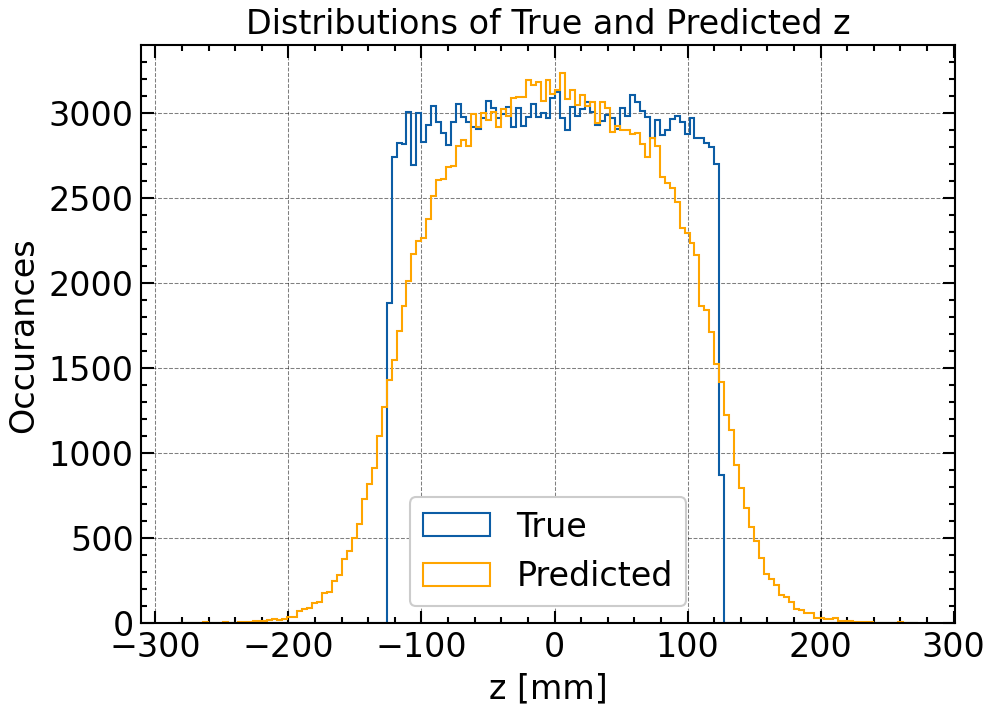

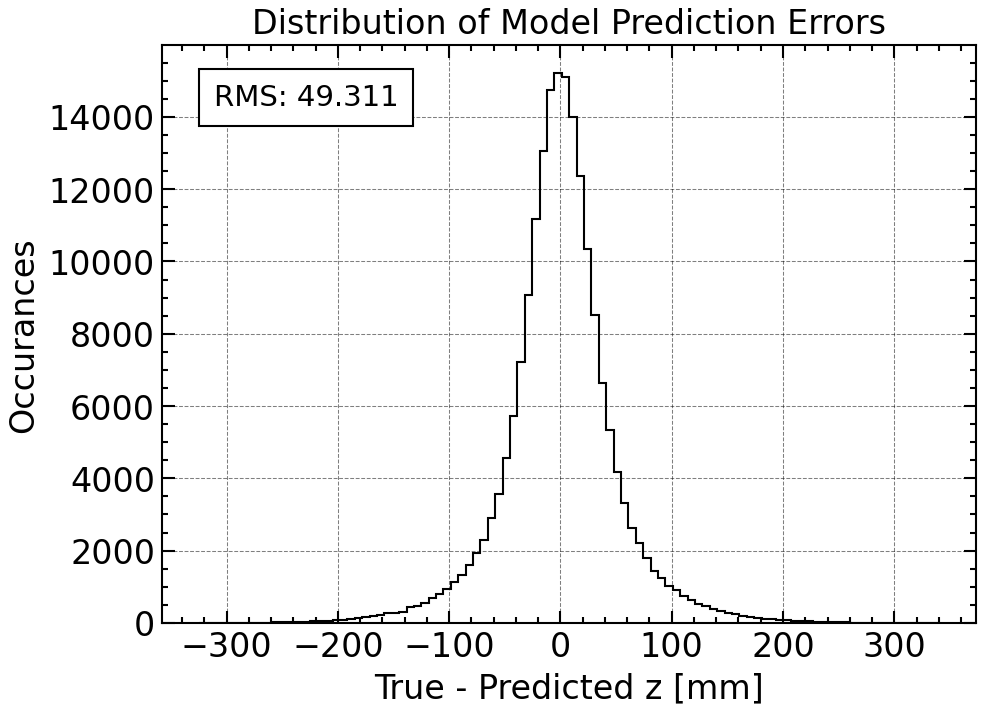

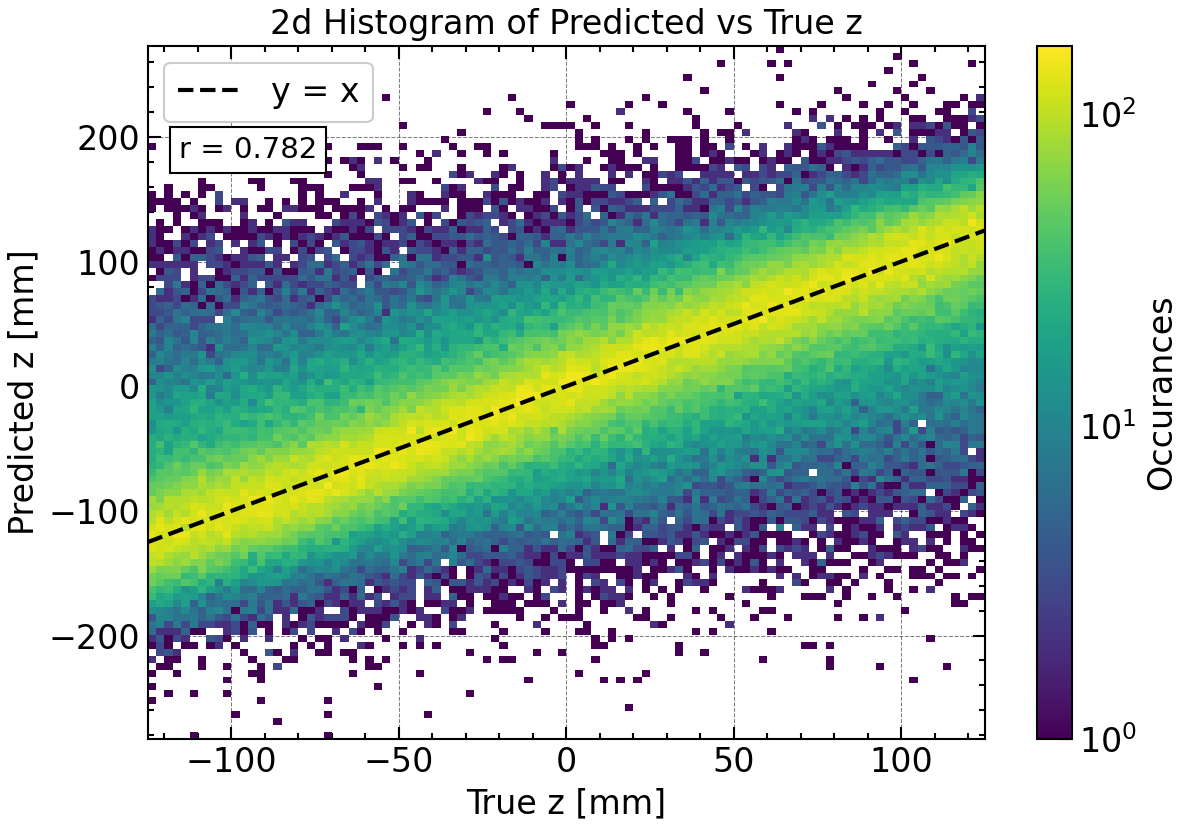

In [22]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

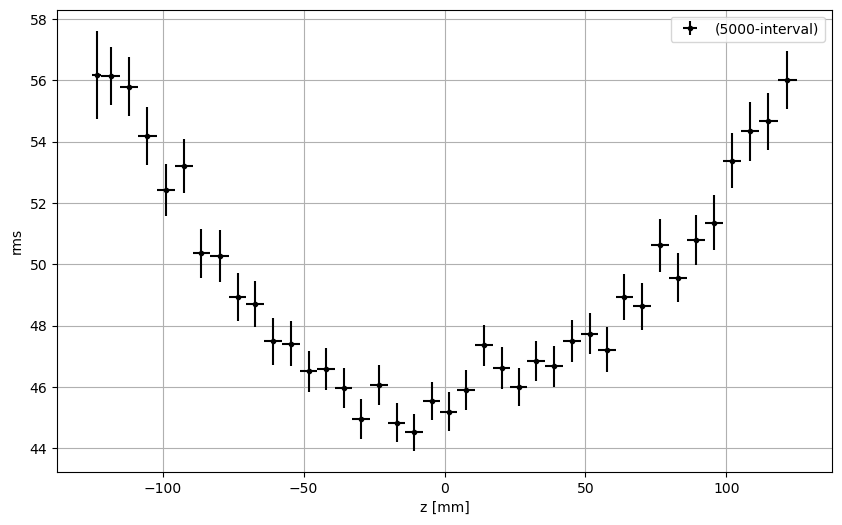

In [23]:
utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

## 2.3 Trained Without Cut, Tested With Cut

In [24]:
# reset
del experiment

electrons = Experiment(electrons_df, config=FIVE_LAYERS)
electrons.standard_procedure()

photons = Experiment(photons_df, config=FIVE_LAYERS)
photons.standard_procedure()

pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
pi0.standard_procedure()

pi_char = Experiment(pi_char_df, config=FIVE_LAYERS)
pi_char.standard_procedure()

del electrons_df, photons_df, pi0_df, pi_char_df

# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

experiment = electrons + photons + pi0 + pi_char

del electrons, photons, pi0, pi_char
experiment.shuffle_dataset(repeats=11)

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998
INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870
INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483
INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 

In [25]:
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)

experiment.z_cut(z_threshold=125, data="training")
print(experiment.X_train.shape)

experiment.train_xgboost_model(params)

(790421, 22)
INFO: Trained XGBoost model; mean squared error: 5320.095703165236


5320.095703165236

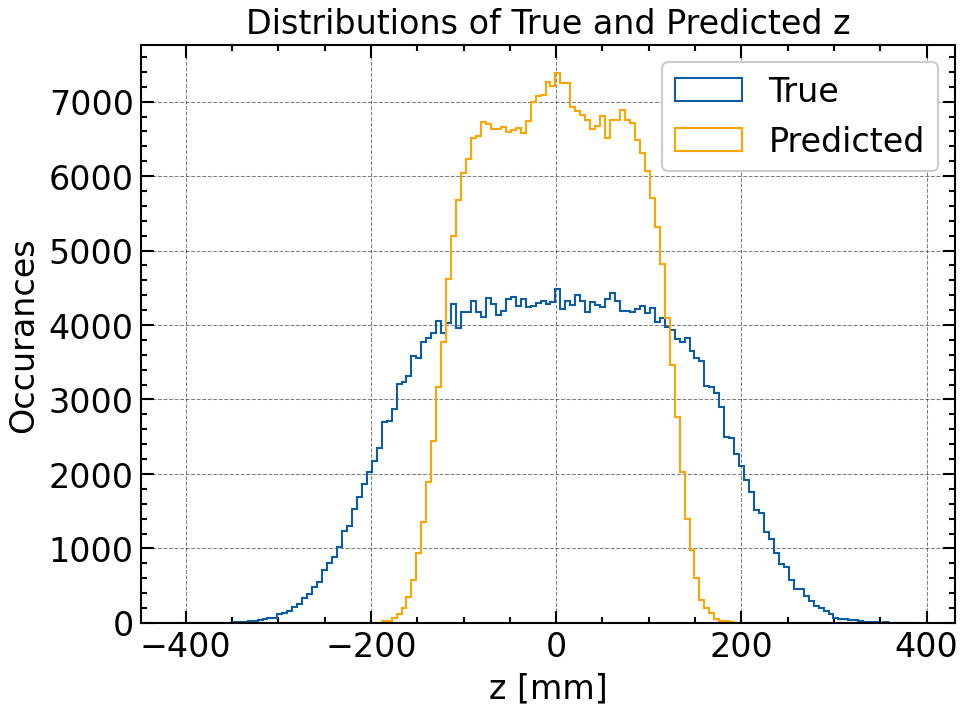

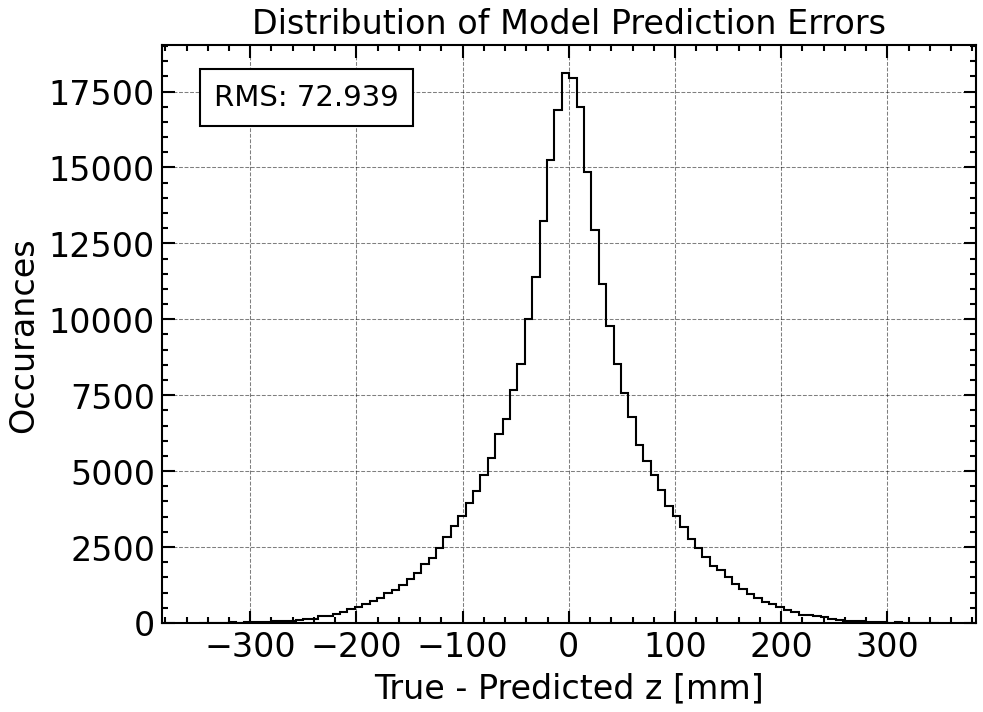

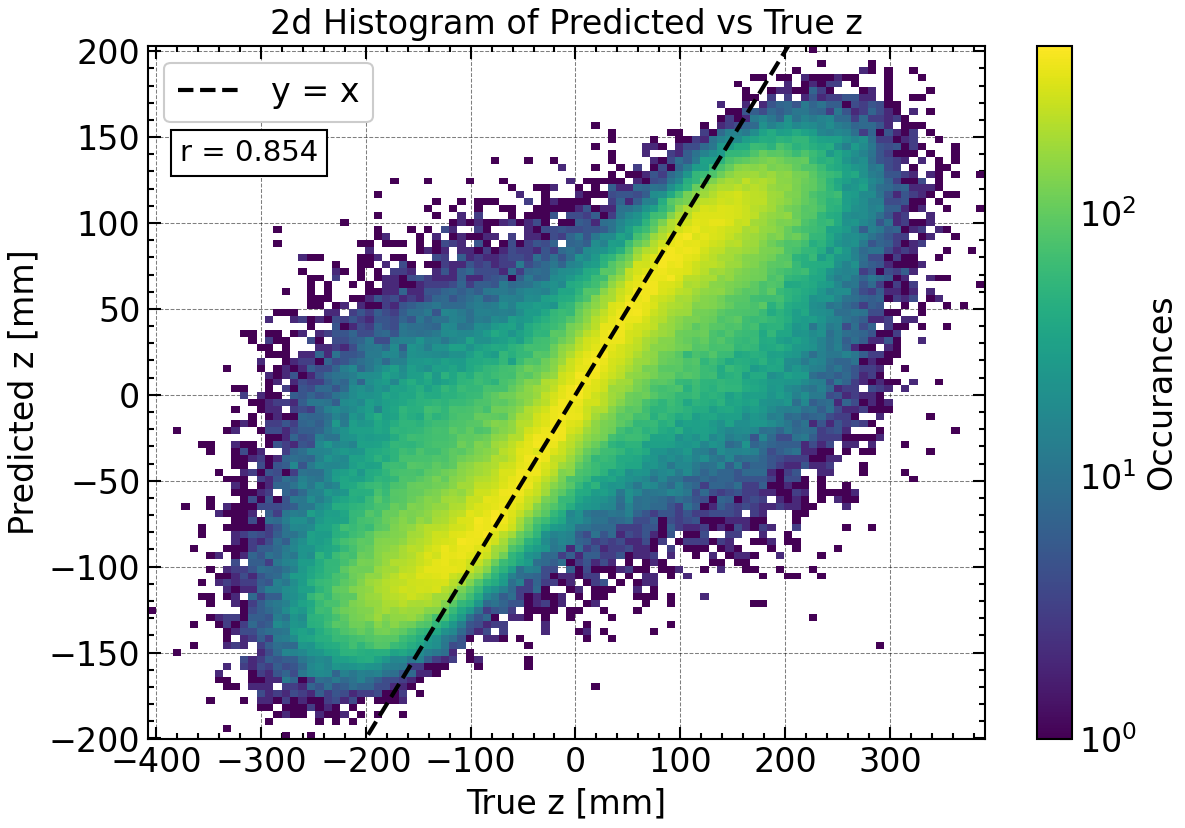

In [26]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

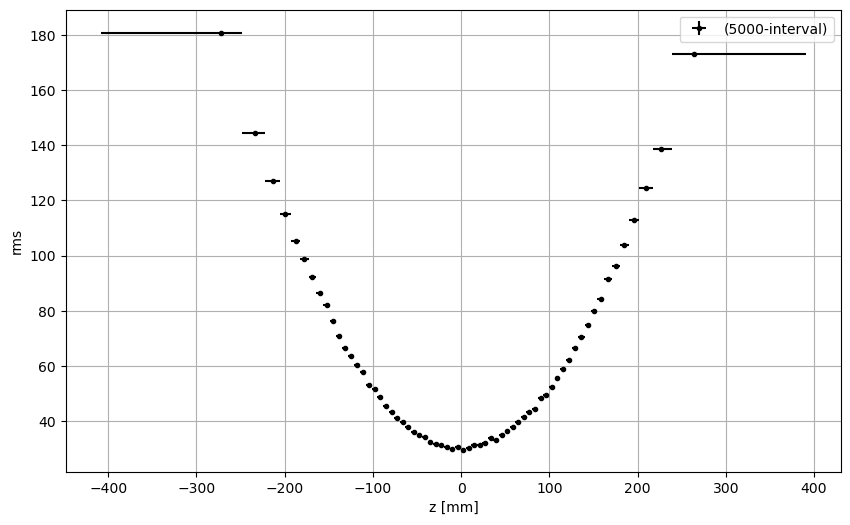

In [27]:
x_c, y_c, x_u_c, y_u_c = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

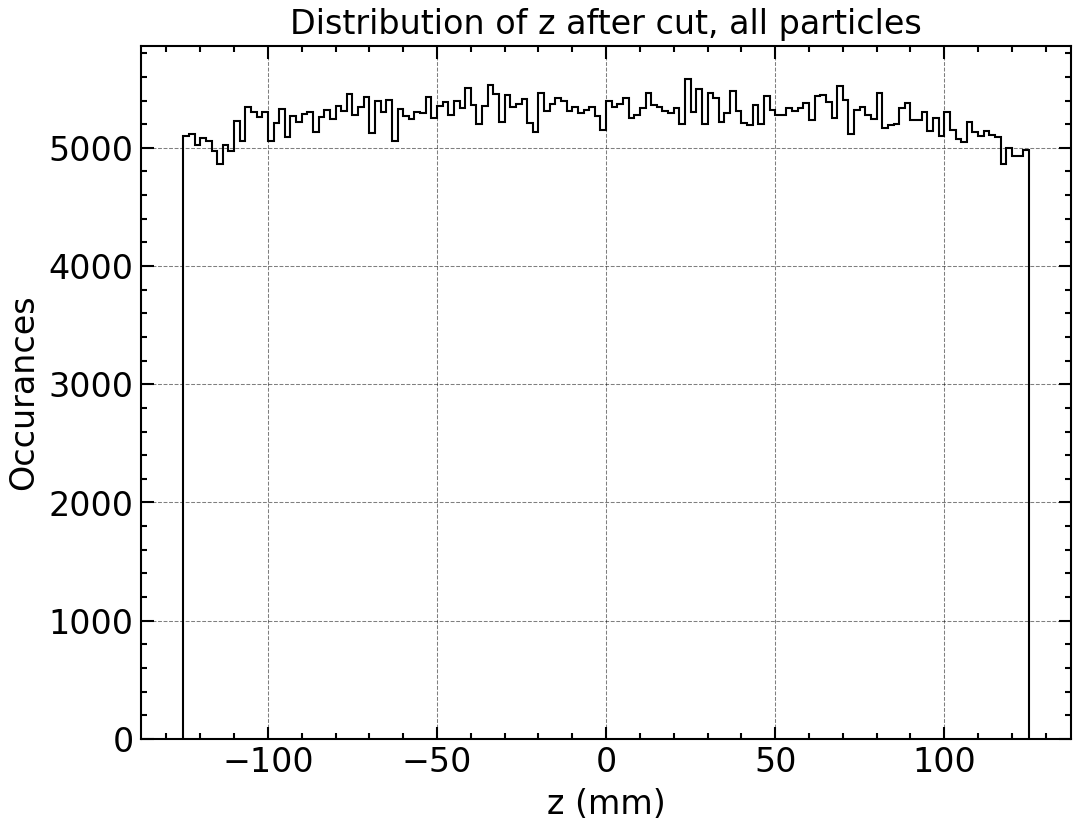

In [46]:
with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(8, 6), dpi=150)
    plt.hist(
        experiment.training_dataset.z,
        bins=150,
        histtype="step",
        color="k",
        density=False,
    )
    plt.xlabel("z (mm)")
    plt.ylabel("Occurances")
    plt.title("Distribution of z after cut, all particles")
    plt.show()

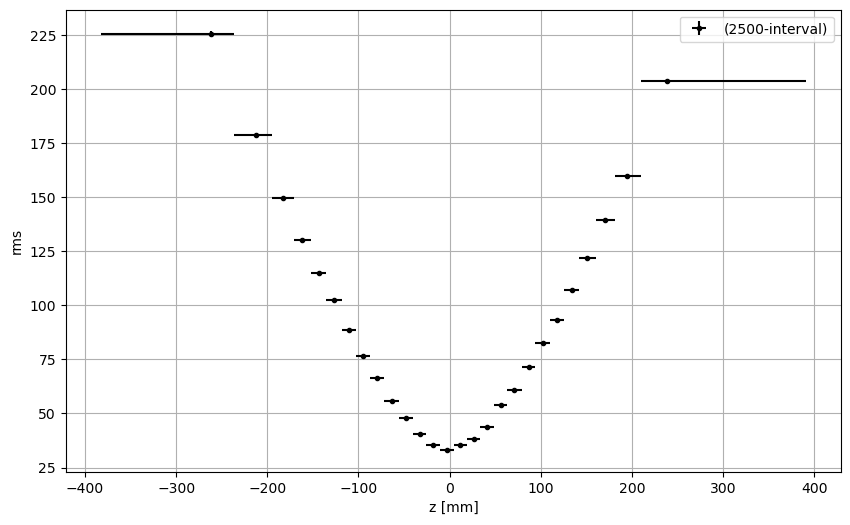

In [29]:
x_e_cz, y_e_cz, x_u_e_cz, u_e_cz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=3000,
    xlabel="z [mm]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

x_p_cz, y_p_cz, x_u_p_cz, u_p_cz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2500,
    xlabel="z [mm]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi0_cz, y_pi0_cz, x_u_pi0_cz, u_pi0_cz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="z [mm]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi_char_cz, y_pi_char_cz, x_u_pi_char_cz, u_pi_char_cz = utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="z [mm]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

## 2.4 Trained With Cut, Tested With Cut

In [30]:
experiment.z_cut(z_threshold=125, data="testing")
print(experiment.X_test.shape)

experiment.train_xgboost_model(params)

(197286, 22)
INFO: Trained XGBoost model; mean squared error: 1792.2622225063817


1792.2622225063817

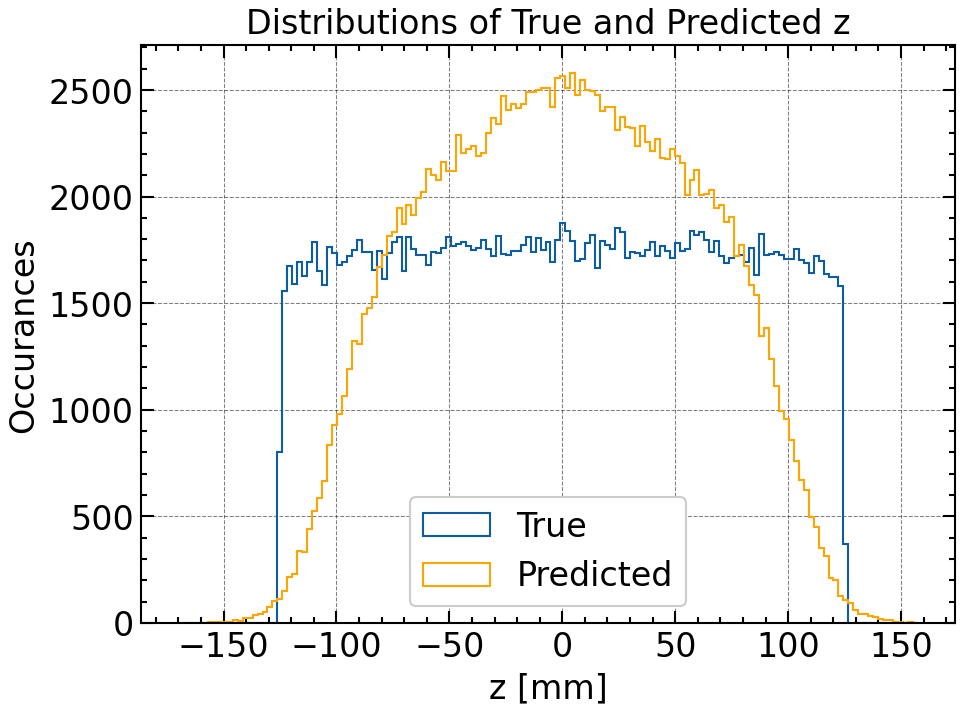

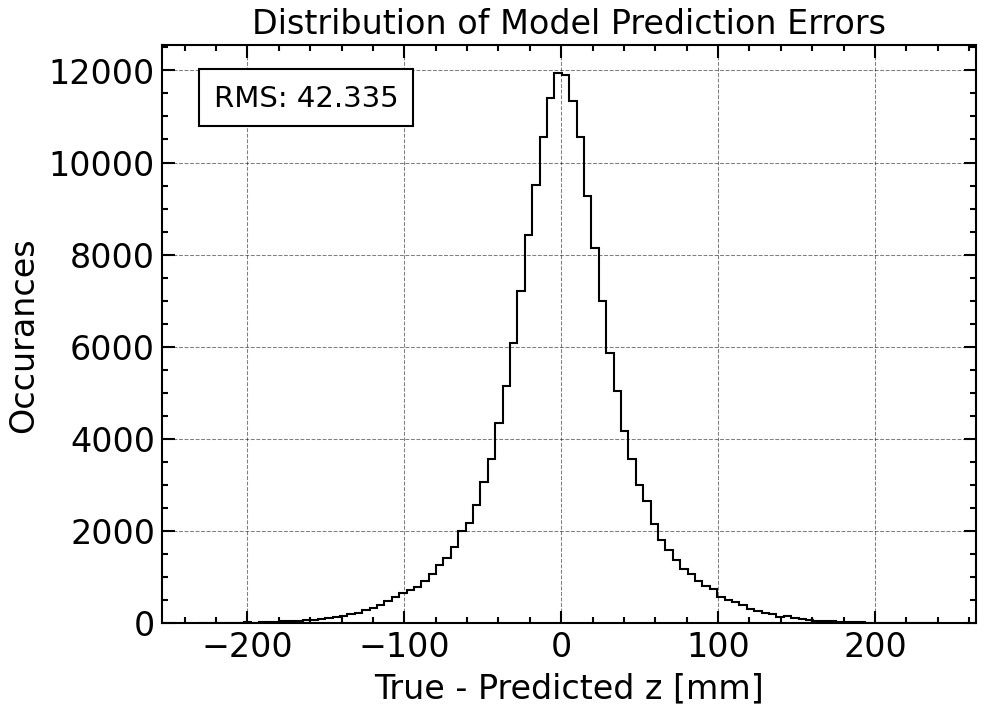

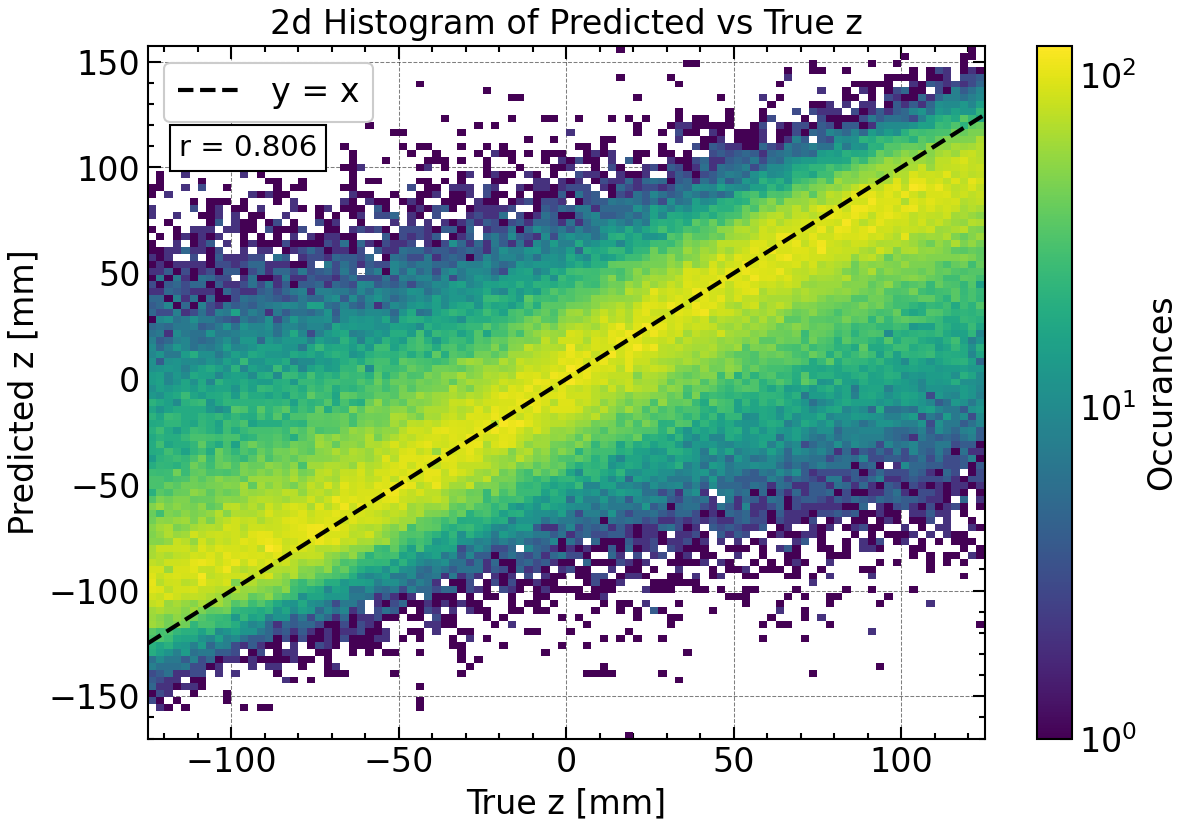

In [31]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

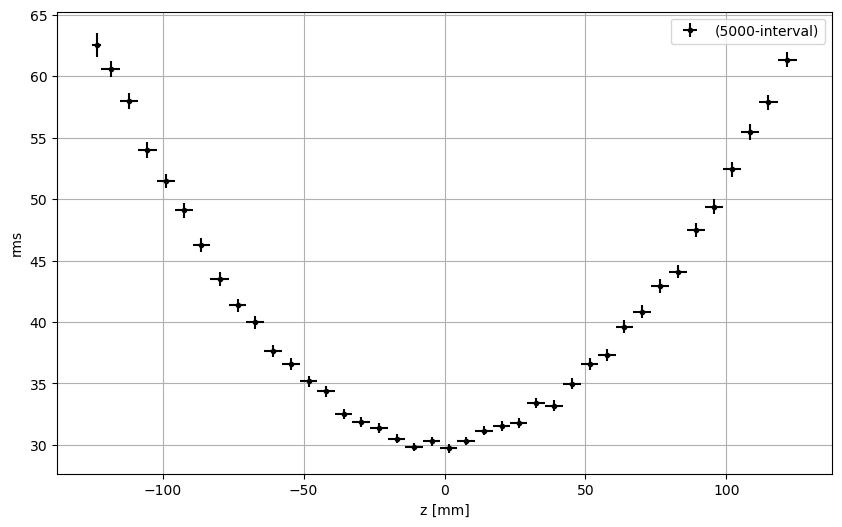

In [32]:
utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

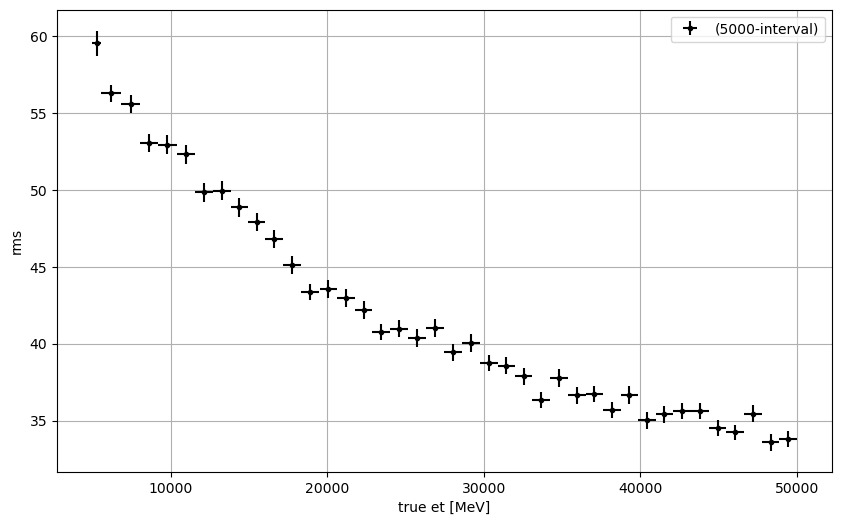

In [33]:
utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

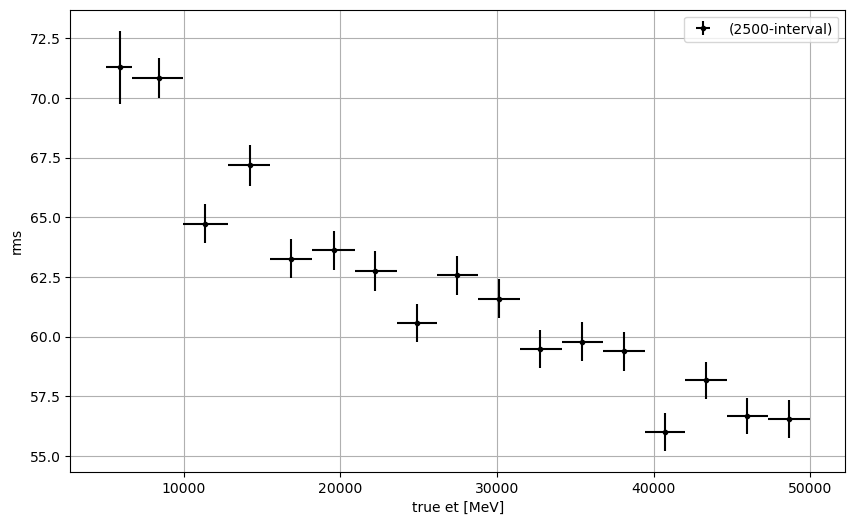

In [34]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

x_e_ce, y_e_ce, x_u_e_ce, u_e_ce = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

x_p_ce, y_p_ce, x_u_p_ce, u_p_ce = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi0_ce, y_pi0_ce, x_u_pi0_ce, u_pi0_ce = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi_char_ce, y_pi_char_ce, x_u_pi_char_ce, u_pi_char_ce = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

# Comparison Plots

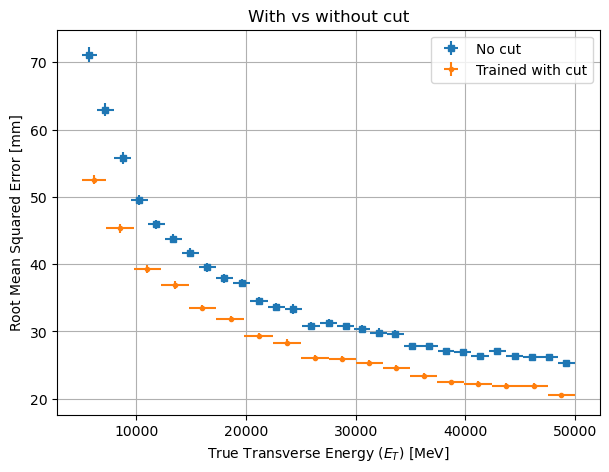

In [35]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    x_e_ne,
    y_e_ne,
    xerr=x_u_e_ne,
    yerr=u_e_ne,
    fmt="s",
    markersize=4,
    label="No cut",
)
plt.errorbar(
    x_e_ce, y_e_ce, xerr=x_u_e_ce, yerr=u_e_ce, fmt=".", label="Trained with cut"
)


# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("With vs without cut")

plt.legend()
plt.grid()
plt.show()

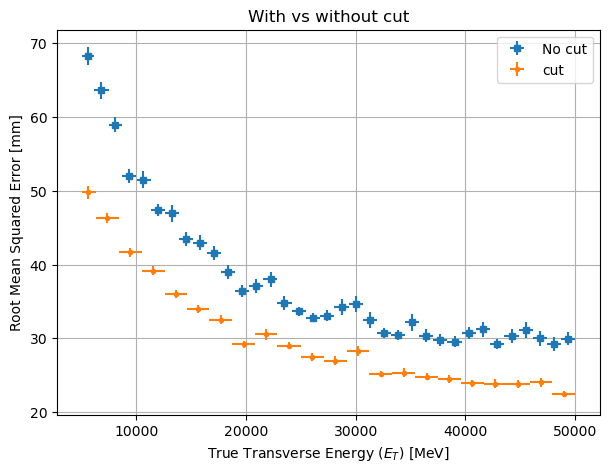

In [36]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    x_p_ne,
    y_p_ne,
    xerr=x_u_p_ne,
    yerr=u_p_ne,
    fmt="s",
    markersize=4,
    label="No cut",
)
plt.errorbar(x_p_ce, y_p_ce, xerr=x_u_p_ce, yerr=u_p_ce, fmt=".", label="cut")


# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("With vs without cut")

plt.legend()
plt.grid()
plt.show()

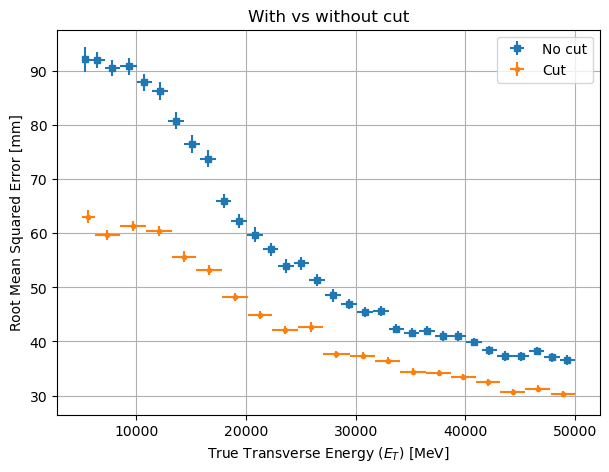

In [37]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    x_pi0_ne,
    y_pi0_ne,
    xerr=x_u_pi0_ne,
    yerr=u_pi0_ne,
    fmt="s",
    markersize=4,
    label="No cut",
)
plt.errorbar(
    x_pi0_ce,
    y_pi0_ce,
    xerr=x_u_pi0_ce,
    yerr=u_pi0_ce,
    fmt=".",
    label="Cut",
)


# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("With vs without cut")

plt.legend()
plt.grid()
plt.show()

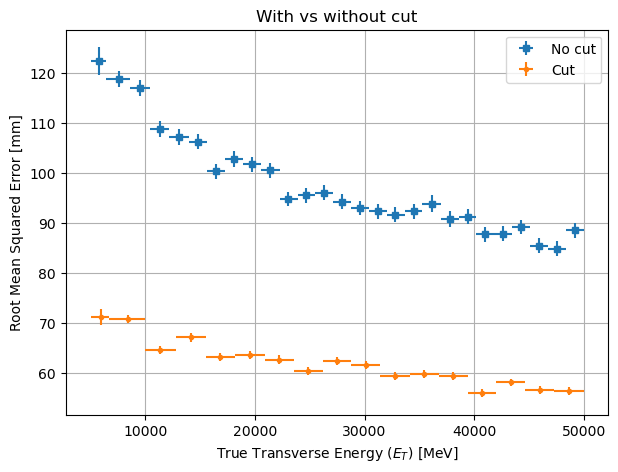

In [38]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    x_pi_char_ne,
    y_pi_char_ne,
    xerr=x_u_pi_char_ne,
    yerr=u_pi_char_ne,
    fmt="s",
    markersize=4,
    label="No cut",
)
plt.errorbar(
    x_pi_char_ce,
    y_pi_char_ce,
    xerr=x_u_pi_char_ce,
    yerr=u_pi_char_ce,
    fmt=".",
    label="Cut",
)


# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("With vs without cut")

plt.legend()
plt.grid()
plt.show()

# z plots

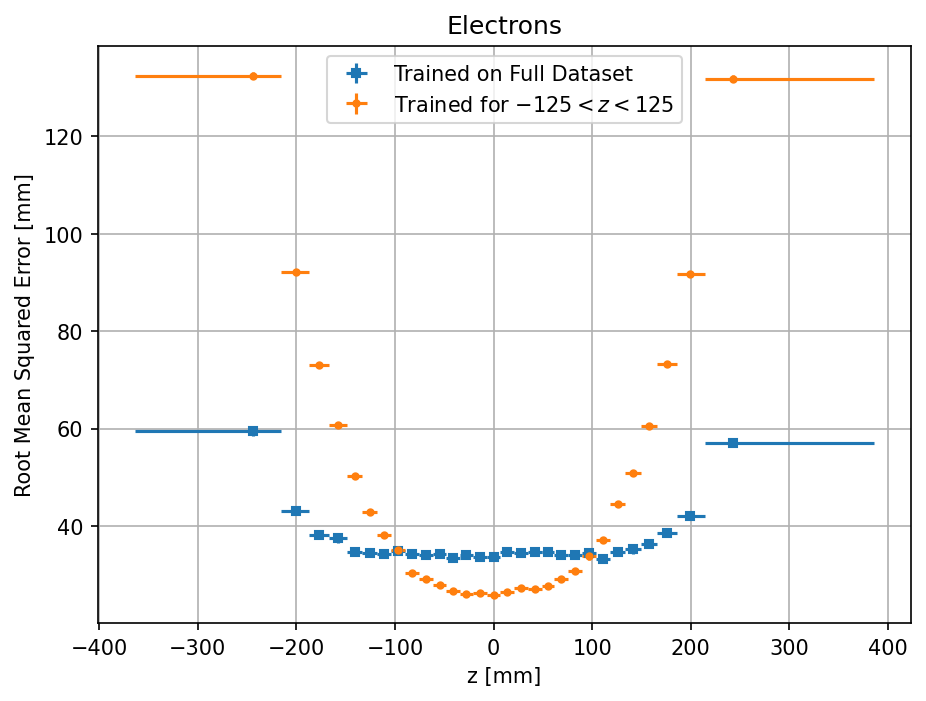

In [39]:
plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(
    x_e_nz,
    y_e_nz,
    xerr=x_u_e_nz,
    yerr=u_e_nz,
    fmt="s",
    markersize=4,
    label="Trained on Full Dataset",
)
plt.errorbar(
    x_e_cz,
    y_e_cz,
    xerr=x_u_e_cz,
    yerr=u_e_cz,
    fmt=".",
    label=r"Trained for $-125<z<125$",
)


# Adding labels and title
plt.xlabel(r"z [mm]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Electrons")

plt.legend()
plt.grid()
plt.show()

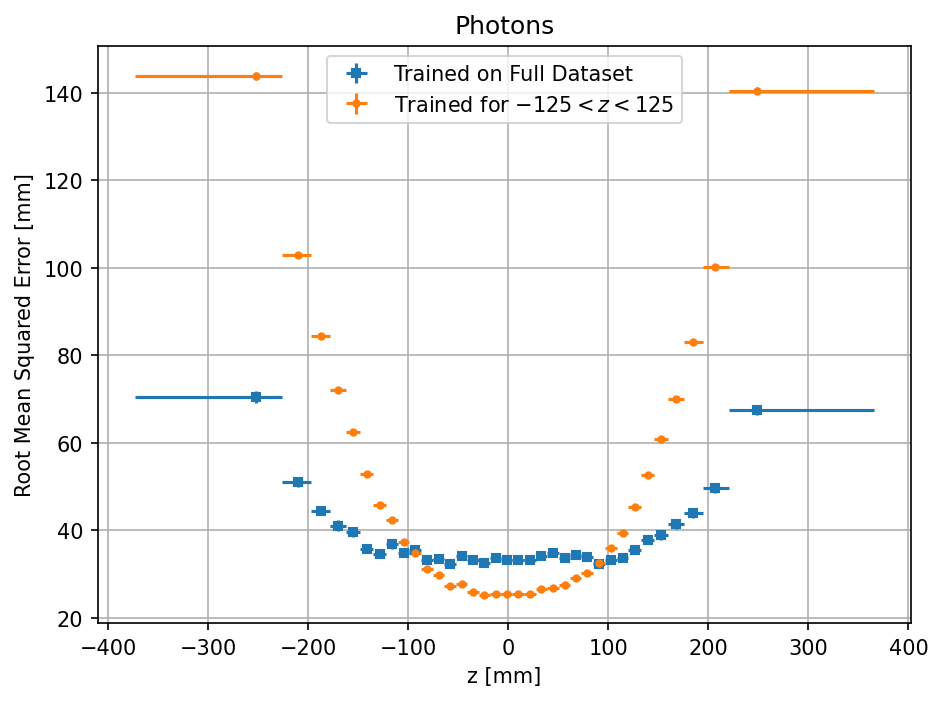

In [40]:
plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(
    x_p_nz,
    y_p_nz,
    xerr=x_u_p_nz,
    yerr=u_p_nz,
    fmt="s",
    markersize=4,
    label="Trained on Full Dataset",
)
plt.errorbar(
    x_p_cz,
    y_p_cz,
    xerr=x_u_p_cz,
    yerr=u_p_cz,
    fmt=".",
    label=r"Trained for $-125<z<125$",
)


# Adding labels and title
plt.xlabel(r"z [mm]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Photons")

plt.legend()
plt.grid()
plt.show()

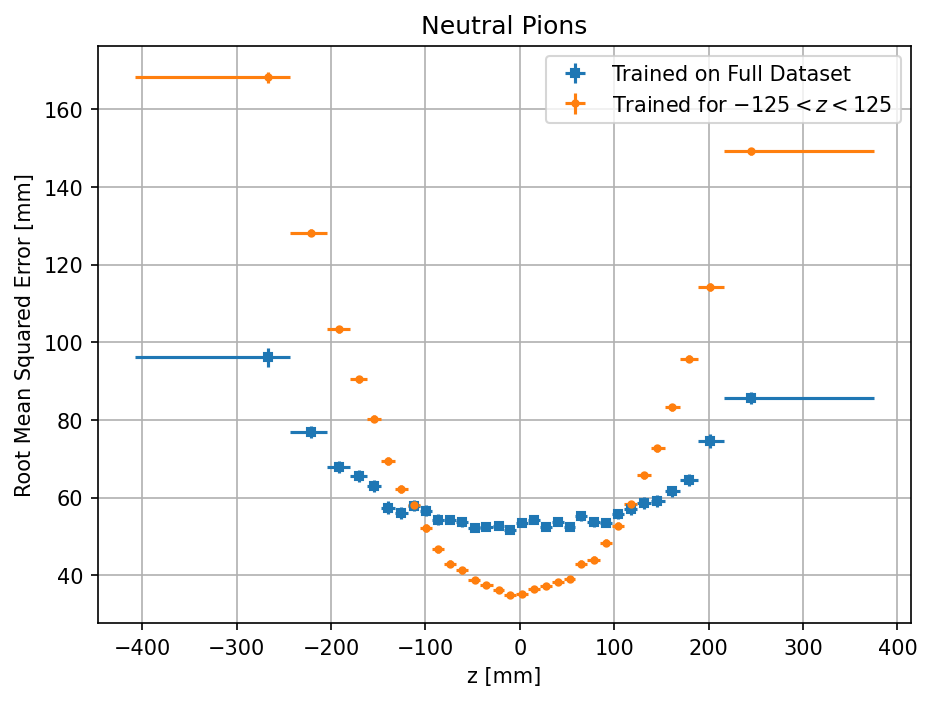

In [41]:
plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(
    x_pi0_nz,
    y_pi0_nz,
    xerr=x_u_pi0_nz,
    yerr=u_pi0_nz,
    fmt="s",
    markersize=4,
    label="Trained on Full Dataset",
)
plt.errorbar(
    x_pi0_cz,
    y_pi0_cz,
    xerr=x_u_pi0_cz,
    yerr=u_pi0_cz,
    fmt=".",
    label=r"Trained for $-125<z<125$",
)


# Adding labels and title
plt.xlabel(r"z [mm]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Neutral Pions")

plt.legend()
plt.grid()
plt.show()

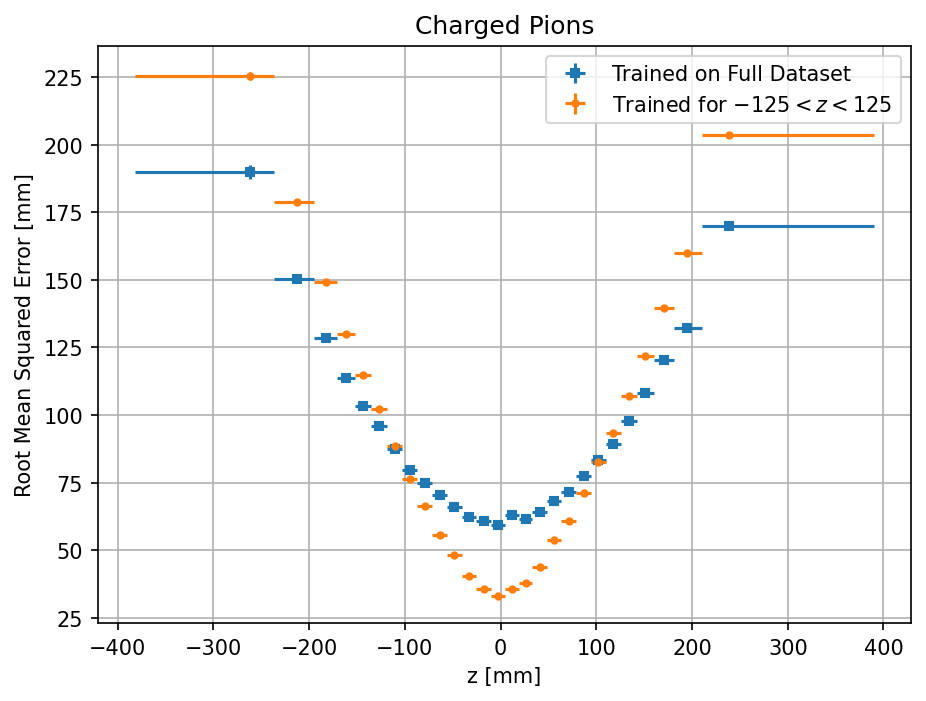

In [42]:
plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(
    x_pi_char_nz,
    y_pi_char_nz,
    xerr=x_u_pi_char_nz,
    yerr=u_pi_char_nz,
    fmt="s",
    markersize=4,
    label="Trained on Full Dataset",
)
plt.errorbar(
    x_pi_char_cz,
    y_pi_char_cz,
    xerr=x_u_pi_char_cz,
    yerr=u_pi_char_cz,
    fmt=".",
    label=r"Trained for $-125<z<125$",
)


# Adding labels and title
plt.xlabel(r"z [mm]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Charged Pions")

plt.legend()
plt.grid()
plt.show()

In [43]:
2**5

32

In [44]:
600 * (32 + 16 + 8 + 4 + 2 + 1)

37800

In [45]:
600 * (2**6 - 1)

37800